In [1]:
import pandas as pd

file_path = 'date_promovare_examen.csv'
df = pd.read_csv(file_path)
 
df.describe()

,Ore_Studiu,Ore_Somn,Promovare
count,500.000000,500.000000,500.000000
mean,4.006780,6.515760,0.500000
std,2.221241,1.531357,0.500501
min,-1.240000,3.790000,0.000000
25%,2.005000,5.070000,0.000000
50%,4.090000,6.485000,0.500000
75%,6.060000,7.970000,1.000000
max,9.850000,9.290000,1.000000


In [2]:
promovare_counts = df['Promovare'].value_counts()
promovare_counts

Promovare
1    250
0    250
Name: count, dtype: int64

In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

X_studiu = df['Ore_Studiu'].values
X_somn = df['Ore_Somn'].values
y = df['Promovare'].values

with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_studiu = pm.Normal('beta_studiu', mu=0, sigma=1)
    beta_somn = pm.Normal('beta_somn', mu=0, sigma=1)
    
    mu = alpha + beta_studiu * X_studiu + beta_somn * X_somn
    
    teta = pm.Deterministic('teta', pm.math.sigmoid(mu))

    y_obs = pm.Bernoulli('y_obs', teta, observed=y)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

pm.summary(trace)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_studiu, beta_somn]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-7.758,0.630,-8.909,-6.554,0.011,0.008,3199.0,3293.0,1.0
beta_studiu,1.467,0.206,1.078,1.847,0.004,0.003,2520.0,2802.0,1.0
beta_somn,0.327,0.164,0.033,0.651,0.003,0.002,2250.0,2828.0,1.0
teta[0],0.989,0.005,0.980,0.996,0.000,0.000,4937.0,4270.0,1.0
teta[1],0.976,0.008,0.960,0.990,0.000,0.000,5126.0,4887.0,1.0
...,...,...,...,...,...,...,...,...,...
teta[495],0.082,0.018,0.050,0.115,0.000,0.000,4742.0,4995.0,1.0
teta[496],0.014,0.008,0.002,0.029,0.000,0.000,2650.0,3372.0,1.0
teta[497],0.035,0.012,0.015,0.058,0.000,0.000,3182.0,3773.0,1.0
teta[498],0.011,0.005,0.003,0.020,0.000,0.000,3194.0,3712.0,1.0


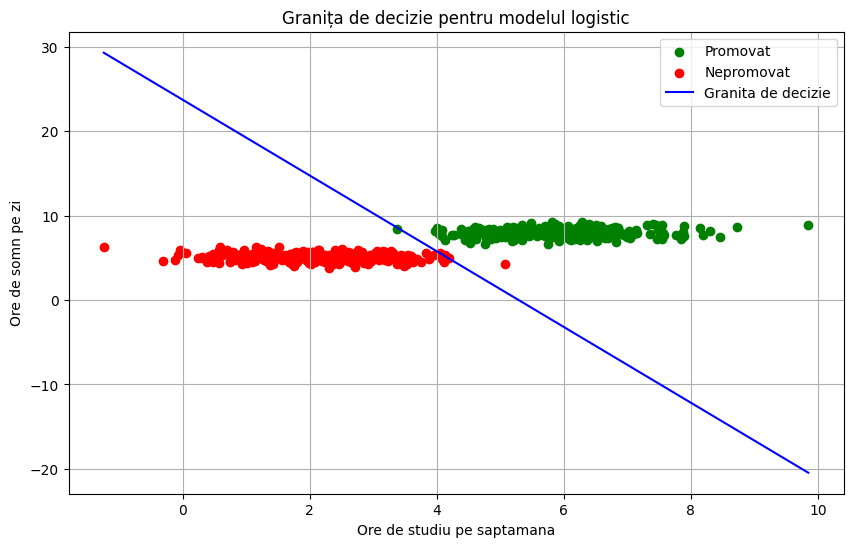

In [4]:
alpha_mean = trace.posterior['alpha'].mean().item()
beta_studiu_mean = trace.posterior['beta_studiu'].mean().item()
beta_somn_mean = trace.posterior['beta_somn'].mean().item()

def decision_boundary(x_studiu):
    return -(alpha_mean + beta_studiu_mean * x_studiu) / beta_somn_mean

x_studiu_vals = np.linspace(X_studiu.min(), X_studiu.max(), 100)
x_somn_vals = decision_boundary(x_studiu_vals)

plt.figure(figsize=(10, 6))
plt.scatter(df['Ore_Studiu'][df['Promovare'] == 1], df['Ore_Somn'][df['Promovare'] == 1], 
            color='green', label='Promovat')
plt.scatter(df['Ore_Studiu'][df['Promovare'] == 0], df['Ore_Somn'][df['Promovare'] == 0], 
            color='red', label='Nepromovat')
plt.plot(x_studiu_vals, x_somn_vals, color='blue', label='Granita de decizie')

plt.xlabel('Ore de studiu pe saptamana')
plt.ylabel('Ore de somn pe zi')
plt.title('Granița de decizie pentru modelul logistic')
plt.legend()
plt.grid(True)
plt.show()
